# The Water Challenge: The Evian Round (Python)

- draft version 1
- part 1 of a planned 7-part project (*see* **Project outline**)
- **Python** version; *see* [**Github** folder](https://github.com/tros01/projects) for the **R** version
- *see* **Notes and reference material** for links to research notes and references
- *see* **Playlist** for the soundtrack
- [**contact me via LinkedIn**](https://www.linkedin.com/in/tomas-rosecky-uk/)

## Experiment summary

Suspended.

## Data and workings

In [2]:
# Libraries
import math
import statistics
import numpy as np
import pandas as pd
import random
from plotnine import ggplot, aes, geom_line, theme_minimal, theme, labs, scale_color_manual
from scipy.stats import binom, norm
import cmdstanpy
import arviz as az
import logging

# Session seed
random.seed(101)

In [3]:
# Commons
root_folder = r"D:\data_save\h20_round1"

### Sampling

We have generated two vectors with values B (for a black can) and G (for a green can). These two vectors of pseudorandom values have dictated the order in which samples have been handed out to participants in two separate subsamples.

Below, we check the path of each vector as a random walk. For each sample B we subtract 1; for each sample G we add 1 and cumulate the path of the draws. We report the summary statistics (mean and variance) for each vector. Lastly, we validate the randomness of draws in each vector.

In [4]:
# Order vector
outcome_vector = ("B", "G")
seq_size = 45

```R
# R code
sample_df1 <- tibble(
    sampling_order_a = seq(seq_size),
    sample_a = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
) |>
    mutate(
        sampling_order_b = sampling_order_a + seq_size,
        sample_b = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
    )
sample_df1 |> head(n=10)

sample_df2 <- tibble(
    sampling_order_c = seq(seq_size),
    sample_c = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
) |>
    mutate(
        sampling_order_d = sampling_order_c + seq_size,
        sample_d = sample(outcome_vector, seq_size, replace = TRUE, prob = c(rep(1 / length(outcome_vector), length(outcome_vector))))
    )
sample_df2 |> head(n=10)
```

In [5]:
sample_df1 = pd.read_excel(
    root_folder + r"\sample_vector1.xlsx",
    sheet_name=0,
    header=None,
    skiprows=1, 
    nrows=None
)

print("\n#### Sample vector 1:\n")
sample_df1.head()


#### Sample vector 1:



,0,1,2,3
0,1,B,46,B
1,2,B,47,B
2,3,G,48,B
3,4,B,49,B
4,5,B,50,B


In [6]:
sample_df2 = pd.read_excel(
    root_folder + r"\sample_vector2.xlsx",
    sheet_name=0,
    header=None,
    skiprows=1, 
    nrows=None
)

print("\n#### Sample vector 2:\n")
sample_df2.head()


#### Sample vector 2:



,0,1,2,3
0,1,G,46,G
1,2,G,47,B
2,3,B,48,B
3,4,B,49,G
4,5,B,50,B


In [7]:
# Bind the vectors and data frames, recode values
code_map = {"B": -1, "G": 1}

sampling_draws = pd.DataFrame({
    "sample_order": pd.concat([sample_df1.iloc[:,0], sample_df1.iloc[:,2]], axis=0),
    "vector1": pd.concat([sample_df1.iloc[:,1], sample_df1.iloc[:,3]], axis=0).map(code_map),
    "vector2": pd.concat([sample_df2.iloc[:,1], sample_df2.iloc[:,3]], axis=0).map(code_map)
}).reset_index(drop=True)

# Cumulate the draws
sampling_draws["vec1_cumsum"] = sampling_draws["vector1"].cumsum()
sampling_draws["vec2_cumsum"] = sampling_draws["vector2"].cumsum()

# Infix colnames with underscores
sampling_draws_renamed = sampling_draws.copy()
sampling_draws_renamed.columns = sampling_draws_renamed.columns.str.replace(
    r"vec(\d+)_cumsum", r"cumsum_\1", regex=True
).str.replace(r"vector(\d+)", r"vector_\1", regex=True)

sampling_draws_renamed["id"] = range(len(sampling_draws_renamed))

# Pivot the columns
sampling_draws_long = pd.wide_to_long(
    sampling_draws_renamed,
    stubnames=["vector", "cumsum"],
    i=["id", "sample_order"],
    j="vector_num",
    sep="_"
).reset_index()

print("\n#### Recoded vector of sample draws:\n")
sampling_draws_long.head()


#### Recoded vector of sample draws:



,id,sample_order,vector_num,vector,cumsum
0,0,1,1,-1,-1
1,0,1,2,1,1
2,1,2,1,-1,-2
3,1,2,2,1,2
4,2,3,1,1,-1



#### Figure 1: First round sampling orders:



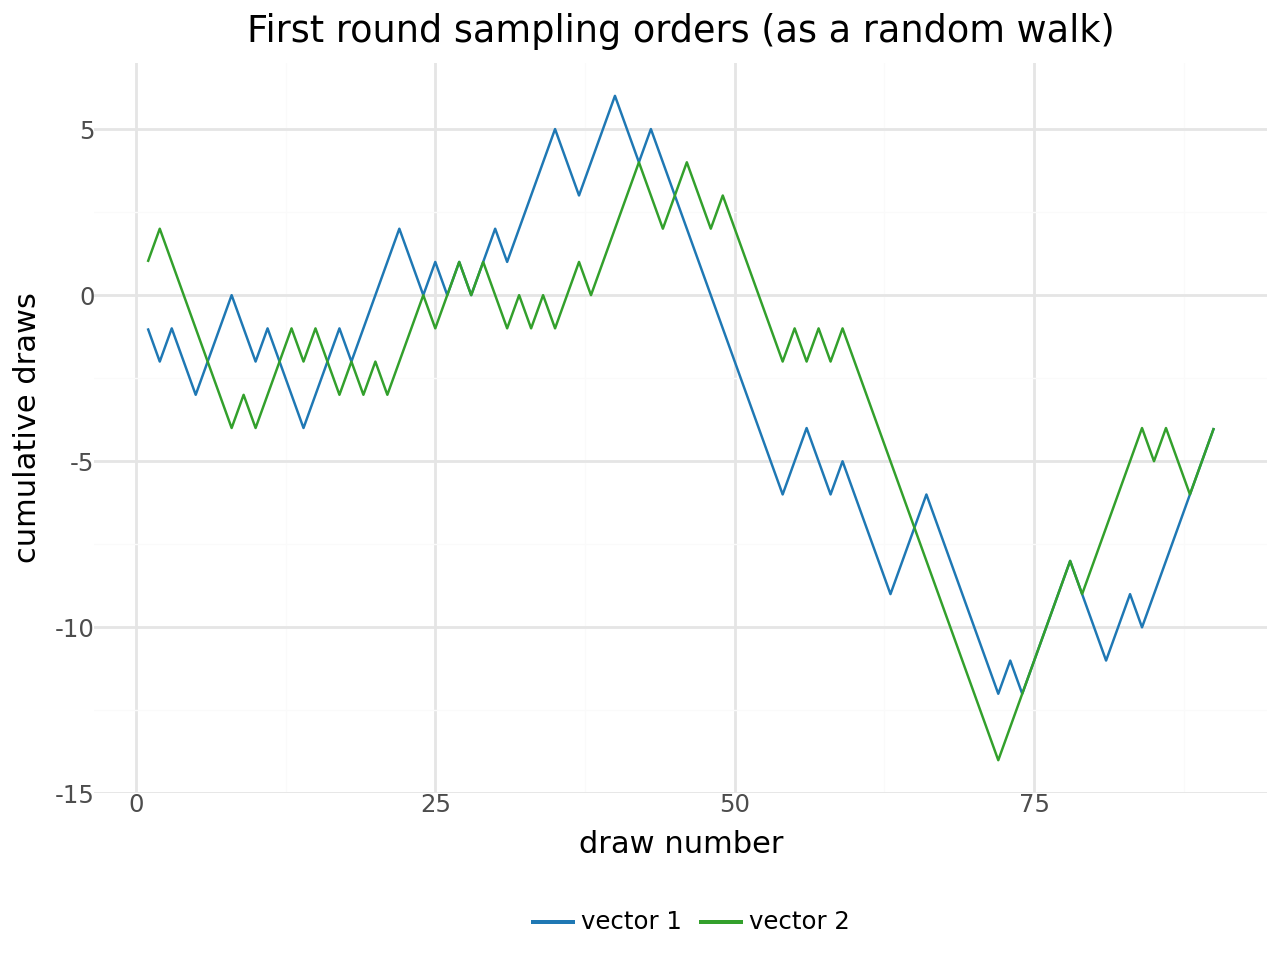

In [8]:
print("\n#### Figure 1: First round sampling orders:\n")

# Construct labels
sampling_draws_long["vector_label"] = sampling_draws_long["vector_num"].map({
    1: "vector 1",
    2: "vector 2"
})

(
    ggplot(sampling_draws_long, aes(x="sample_order", y="cumsum", color="vector_label")) +
    geom_line() +
    theme_minimal() +
    theme(legend_position="bottom") +
    labs(
        x="draw number",
        y="cumulative draws",
        color="",
        title="First round sampling orders (as a random walk)"
    ) +
    scale_color_manual(
        values={"vector 1": "#1f78b4", "vector 2": "#33a02c"}
    )
)

In [9]:
# Compute descriptive statistics
sampling_vector_summary_stats = pd.DataFrame({
    "mean": [statistics.mean(sampling_draws.vector1), statistics.mean(sampling_draws.vector2)],
    "variance": [statistics.variance(sampling_draws.vector1), statistics.variance(sampling_draws.vector2)]
})

sampling_vector_summary_stats.rename(index={0: "vector1", 1: "vector2"}, inplace=True)

print("\n#### Mean and variance of the sampling vectors:\n")
sampling_vector_summary_stats


#### Mean and variance of the sampling vectors:



,mean,variance
vector1,-0.044444,1.009238
vector2,-0.044444,1.009238


In [10]:
# Validate the randomness
    # Vector identity

print("\n#### Are the vectors identical?\n")
sampling_draws.vector1.equals(sampling_draws.vector2)


#### Are the vectors identical?



False

In [11]:
    # Proportion of identical elements

print("\n#### What is the proportion of identical elements?\n")
sum(sampling_draws.vector1 == sampling_draws.vector2) / sampling_draws.shape[0]


#### What is the proportion of identical elements?



0.5333333333333333

In [12]:
    # Probability the means are equal
n = sampling_draws.shape[0]
theta = 1 / len(outcome_vector)

print("\n#### What is the probability the means will be identical?\n")
sum([binom.pmf(i, n, theta) ** 2 for i in range(0,n)])


#### What is the probability the means will be identical?



np.float64(0.05938826329074258)

### Data

In [13]:
# Extract col names
header = pd.read_excel(
    root_folder + r"\id_df.xlsx",
    sheet_name="round1a",
    header=None,
    skiprows=1, 
    nrows=1
)

col_names = dict(zip(
    list(range(header.shape[1])),
    header.iloc[0,:]
))

In [14]:
# Table cohort 1
df1 = pd.read_excel(
    root_folder + r"\id_df.xlsx",
    sheet_name="round1a",
    header=None,
    skiprows=3, 
    nrows=None
)

df1.rename(columns=col_names, inplace=True)

In [15]:
# Table cohort 2
df2 = pd.read_excel(
    root_folder + r"\id_df.xlsx",
    sheet_name="round1b",
    header=None,
    skiprows=3, 
    nrows=None
)

df2.rename(columns=col_names, inplace=True)

#### Clean dataset

In [16]:
# Splice, clean and recode the main df; add matches
df = pd.concat([df1, df2], axis=0)
df = df.loc[:, df.columns != "name"]
df.dropna(inplace=True)

code_map_sample = {"G": 1, "B": 0}
code_map_guess = {"P": 1, "T": 0}
code_map_brand = {1: "evian", 0: "tap"}

df["sample"] = df["sample"].map(code_map_sample)
df["guess"] = df["guess"].map(code_map_guess)
df.batch = df.batch.astype("int32")

df["match"] = df["sample"] == df["guess"]
df["match"] = df["match"].astype("int32")

match_col = df.pop("match")
match_idx = df.columns.get_loc("guess") + 1
df.insert(match_idx, "match", match_col)

df["round_brand"] = df["sample"].map(code_map_brand)
df["round"] = 1

print("\n#### Clean dataset:\n")
print(df)


#### Clean dataset:

        ID  sample  guess  match  confidence  batch      cup round_brand  \
0   ID0001       1      1      1        0.92      1      mug       evian   
1   ID0002       1      1      1        0.95      1      mug       evian   
2   ID0003       0      0      1        0.80      1    glass         tap   
3   ID0004       0      0      1        1.00      1    glass         tap   
4   ID0005       0      1      0        0.80      1    glass         tap   
5   ID0006       0      1      0        0.80      1    glass         tap   
6   ID0007       0      0      1        0.75      1    glass         tap   
7   ID0008       0      0      1        0.90      2    glass         tap   
8   ID0009       1      0      0        1.00      2    glass       evian   
9   ID0010       0      1      0        0.75      2      mug         tap   
10  ID0011       1      1      1        1.00      2    glass       evian   
11  ID0012       1      0      0        0.50      2    glass      

#### Contingency table

In [17]:
contingency_table = pd.DataFrame({
    # Guess potted
    "guess_p": [
        # True positives
        sum((df["sample"] == 1) & (df["guess"] == 1)),
        # False positives
        sum((df["sample"] == 0) & (df["guess"] == 1))
    ],
    # Guess tap
    "guess_t": [
        # False negatives
        sum((df["sample"] == 1) & (df["guess"] == 0)),
        # True negatives
        sum((df["sample"] == 0) & (df["guess"] == 0))
    ]
}).rename(index={0: "sample_p", 1: "sample_t"})

print("\n#### Contingency table (counts):\n")
print(contingency_table)


#### Contingency table (counts):

          guess_p  guess_t
sample_p        6        9
sample_t        5       10


In [18]:
# Frequentist CT
fct = contingency_table.to_numpy()

# Bayesian CT
bct = contingency_table.to_numpy()

### Frequentist analysis

In [19]:
# Critical value
p = 0.05
cv = norm.ppf(1 - p / 2)

In [20]:
# Haldane-Anscombe correction
if 0 in fct:
    fct = fct + 0.5

# Probability of a true positive
fp1 = fct[0,0] / sum(fct[0,:])

# Probability of a false negative
fp2 = fct[1,0] / sum(fct[1,:])

In [21]:
# Risk ratio
rho_hat = fp1 / fp2
    # Standard erros
se_ln_rho = math.sqrt(
    (1 / fct[0,0]) - (1 / fct[0,].sum()) + (1 / fct[1,0]) - (1 / fct[1,].sum())
)
    # Confidence intervals
ci_rho = (
    math.exp(math.log(rho_hat) - cv * se_ln_rho),
    math.exp(math.log(rho_hat) + cv * se_ln_rho)
)

# Odds ratio
theta_hat = (fp1 / (1 - fp1)) / (fp2 / (1 - fp2))
    # Standard errors
se_ln_theta = math.sqrt(
    sum([1 / element for element in fct.flatten()])
)
    # Confidence intervals
ci_theta = (
    math.exp(math.log(theta_hat) - cv * se_ln_theta),
    math.exp(math.log(theta_hat) + cv * se_ln_theta)
)

In [22]:
# Results df
fdf = pd.DataFrame({
    # Frequentist estimates
    "p1": [round(fp1, 3)], "p2": [round(fp2, 3)],
    # Risk ratio estimate (effect size)
    "risk_ratio": [round(rho_hat, 3)],
    # 95pc confidence intervals
    "rr_ci_lo": [round(ci_rho[0], 3)], "rr_ci_hi": [round(ci_rho[1], 3)],
    # Risk ratio significance
    "rr_significance": ["**" if (ci_rho[0] > 1) | (ci_rho[1] < 1) else "-"],
    # Odds ratio estimate (effect size)
    "odds_ratio": [round(theta_hat, 3)],
    # 95pc confidence intervals
    "or_ci_lo": [round(ci_theta[0], 3)], "or_ci_hi": [round(ci_theta[1], 3)],
    # Odds ratio significance
    "or_significance": ["**" if (ci_theta[0] > 1) | (ci_theta[1] < 1) else "-"]
})

print("\n#### Frequentist estimates, risk and odds ratios:\n")
fdf.head()


#### Frequentist estimates, risk and odds ratios:



,p1,p2,risk_ratio,rr_ci_lo,rr_ci_hi,rr_significance,odds_ratio,or_ci_lo,or_ci_hi,or_significance
0,0.4,0.333,1.2,0.466,3.093,-,1.333,0.301,5.915,-


### Bayesian analysis

In [23]:
# Suppress Stan reports bar errors
# logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# Suppress everything
logging.getLogger("cmdstanpy").disabled = True

In [24]:
# Stan script
stan_script = """
data {
    int<lower=1> K; // {treatment, control}
    array[K] int<lower=0> n; // Trials per group
    array[K] int<lower=0> y; // Successes per group
}
parameters {
    vector<lower=0, upper=1>[K] p;
}
model {
    // Jeffreys prior
    p ~ beta(0.5, 0.5);

    // Binomial likelihood
    y ~ binomial(n, p);
}
generated quantities {
    real risk_ratio = p[1] / p[2];
    real odds_ratio = (p[1] / (1 - p[1])) / (p[2] / (1 - p[2]));
}
"""

# Write the Stan model into a file
with open('beta_binomial_model.stan', 'w') as f:
    f.write(stan_script)
    
# Compile the model
mod = cmdstanpy.CmdStanModel(stan_file='beta_binomial_model.stan')

In [25]:
stan_data = {
        "K": 2, # {treatment, control}
        "n": [sum(bct[0]), sum(bct[1])], # Trials per group
        "y": [bct[0,0], bct[1,0]] # Successes per group
    }

print("\n#### Stan data check:\n")
print(stan_data)


#### Stan data check:

{'K': 2, 'n': [np.int64(15), np.int64(15)], 'y': [np.int64(6), np.int64(5)]}


In [26]:
# Sample
fit = mod.sample(
    data = stan_data,
    chains = 6,
    parallel_chains = 6,
    iter_warmup = int(4e2), # 4e3
    iter_sampling = int(16e2), # 16e3
    seed = 42,
    refresh = None, # Suppress progress updates
    show_progress = False # Suppress Stan messages
)

In [27]:
# Sampling diagnostics
inference_data = az.from_cmdstanpy(
    posterior = fit,
    posterior_predictive = None,
    coords={'group': ['treatment', 'control']},
    dims={'p': ['group']}
)
    
print(f"\nSummary statistics and diagnostics:\n")
print(az.summary(inference_data))


Summary statistics and diagnostics:

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p[treatment]  0.405  0.119   0.193    0.634      0.001    0.001    8734.0   
p[control]    0.345  0.114   0.133    0.551      0.001    0.001    7909.0   
risk_ratio    1.335  0.691   0.349    2.562      0.008    0.012    8469.0   
odds_ratio    1.743  1.483   0.154    4.266      0.017    0.036    8607.0   

              ess_tail  r_hat  
p[treatment]    6421.0    1.0  
p[control]      6410.0    1.0  
risk_ratio      6636.0    1.0  
odds_ratio      6639.0    1.0  


In [28]:
# Extract posterior samples
posterior_draws_df = fit.draws_pd()

# Posterior summaries
draws_df = posterior_draws_df[["p[1]", "p[2]", "risk_ratio", "odds_ratio"]]
rr_q = draws_df["risk_ratio"].quantile([0.025, 0.5, 0.975]).values
or_q = draws_df["odds_ratio"].quantile([0.025, 0.5, 0.975]).values

In [29]:
# Results df
bdf = pd.DataFrame({
    # Bayesian estimates
    "p1": [round(draws_df["p[1]"].median(), 3)], "p2": [round(draws_df["p[2]"].median(), 3)],
    # Risk ratio estimate (effect size)
    "risk_ratio": [round(draws_df["risk_ratio"].median(), 3)],
    # 95pc credible bands
    "rr_cb_lo": [round(rr_q[0], 3)], "rr_cb_hi": [round(rr_q[2], 3)],
    # Risk ratio significance
    "rr_significance": ["**" if (rr_q[0] > 1) or (rr_q[2] < 1) else "-"],
    # Odds ratio estimate (effect size)
    "odds_ratio": [round(draws_df["odds_ratio"].median(), 3)],
    # 95pc credible bands
    "or_cb_lo": [round(or_q[0], 3)], "or_cb_hi": [round(or_q[2], 3)],
    # Odds ratio significance
    "or_significance": ["**" if (or_q[0] > 1) or (or_q[2] < 1) else "-"]
})

print("\n#### Bayesian estimates, risk and odds ratios:\n")
bdf.head()


#### Bayesian estimates, risk and odds ratios:



,p1,p2,risk_ratio,rr_cb_lo,rr_cb_hi,rr_significance,odds_ratio,or_cb_lo,or_cb_hi,or_significance
0,0.399,0.338,1.174,0.476,3.117,-,1.297,0.312,5.749,-


### Modified Brier score

In [30]:
# Subset the main df
bs_df = df[["ID", "match", "confidence"]].copy()

# Compute the first-round modified Brier score
bs_df["mb_score"] = (
    bs_df.groupby("ID")["match"]
    .transform(lambda x: ((x - bs_df.loc[x.index, "confidence"]) ** 2).mean())
)

# Compute the inverse adjusted accuracy score
bs_df["rank_score"] = 1 - bs_df.mb_score
bs_df.sort_values(by=["rank_score"], ascending=False, inplace=True)

print(bs_df)

        ID  match  confidence  mb_score  rank_score
3   ID0004      1        1.00    0.0000      1.0000
14  ID0015      1        1.00    0.0000      1.0000
10  ID0011      1        1.00    0.0000      1.0000
20  ID0021      1        1.00    0.0000      1.0000
23  ID0024      1        1.00    0.0000      1.0000
1   ID0002      1        0.95    0.0025      0.9975
0   ID0001      1        0.92    0.0064      0.9936
21  ID0022      1        0.90    0.0100      0.9900
7   ID0008      1        0.90    0.0100      0.9900
2   ID0003      1        0.80    0.0400      0.9600
18  ID0019      1        0.80    0.0400      0.9600
6   ID0007      1        0.75    0.0625      0.9375
24  ID0025      1        0.70    0.0900      0.9100
48  ID0099      1        0.60    0.1600      0.8400
27  ID0028      1        0.60    0.1600      0.8400
22  ID0023      0        0.50    0.2500      0.7500
25  ID0026      0        0.50    0.2500      0.7500
15  ID0016      1        0.50    0.2500      0.7500
16  ID0017  

In [31]:
name_df = pd.concat([df1, df2])[["ID", "name"]].dropna()

bs_ranking = bs_df.merge(name_df, how="left", on="ID")
bs_ranking["rank"] = np.arange(bs_ranking.shape[0]) + 1
bs_ranking = bs_ranking[["rank", "name", "rank_score"]]

# bs_ranking

In [ ]:
# Construct a ranking table
name_df = pd.concat([df1, df2])
name_df = name_df[["ID", "name"]].dropna

bs_ranking = bs_df

## WORK IN PROGRESS

## Save required data